In [37]:
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import gc

In [89]:
pip install timm

  Obtaining dependency information for timm from https://files.pythonhosted.org/packages/7a/bd/2c56be7a3b5bc71cf85a405246b89d5359f942c9f7fb6db6306d9d056092/timm-0.9.7-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.5 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [99]:
from mobile_sam import SamAutomaticMaskGenerator

mask_generator = SamAutomaticMaskGenerator(mobile_sam)
masks = mask_generator.generate("crosswalk.png")

AttributeError: module 'mobile_sam' has no attribute 'image_encoder'

In [84]:
import requests


# MY IMPORT
import requests
import json
import numpy as np
from PIL import Image
import base64
from io import BytesIO

# Define the URL of the server
url = "http://192.168.63.108:5001/process_image"

# Define the headers for the POST request
headers = {
    'Content-Type': 'application/json'
}
with open("newnv_f.png", "rb") as img_file:
    img = Image.open(img_file)
    img = np.array(img).reshape((1208, 1928, 3))
    img_str = base64.b64encode(img).decode('utf-8')
data = {
    'image': img_str
}

response = requests.post(url, headers=headers, data=json.dumps(data))
new_directions = response.json()

In [82]:

from modal import Stub, method
import os
from modal import Image, Secret
import pathlib
import modal
from modal import Mount

def download_models():
    from transformers import AutoModel, AutoTokenizer
    model = AutoModel.from_pretrained("facebook/sam-vit-huge")

image = (
    modal.Image.debian_slim()
    .pip_install("torch", "transformers", "Pillow", "torchvision", "matplotlib", "scikit-image", "openai")
    .run_function(download_models)
)

stub = modal.Stub("chatPID", image=image)

local_dir = pathlib.Path(os.getcwd())
remote_dir = "./"

mount = Mount.from_local_dir(local_dir, remote_path=remote_dir)

@stub.cls(mounts=[mount], gpu="l4")
class ImageProcessor:
    def __enter__(self):
        from transformers import AutoModel
        import os

        self.model = AutoModel.from_pretrained("facebook/sam-vit-huge")
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        pass

    @method()
    def process_img(self, image_path: str) -> dict:
        from transformers import pipeline
        from PIL import Image
        raw_image = Image.open(image_path).convert("RGB")
        aspect_ratio = raw_image.size[0] / raw_image.size[1]
        new_height = 100
        new_width = int(new_height * aspect_ratio)
        raw_image = raw_image.resize((new_width, new_height), Image.LANCZOS)
        width, height = raw_image.size
        left = width * 0.2
        right = width * 0.8
        top = height * 0.25
        bottom = height * 0.8
        raw_image = raw_image.crop((left, top, right, bottom))

        generator = pipeline("mask-generation", model="facebook/sam-vit-huge", device=0)
        outputs = generator(raw_image, points_per_batch=64)
        return outputs, raw_image
    
    @method()
    def process_mask(self, image_path: str) -> dict:
        from transformers import pipeline
        from PIL import Image
        import numpy as np
        import matplotlib.pyplot as plt
        from skimage.measure import label, regionprops
        import gc

        raw_image = Image.open(image_path).convert("RGB")
        aspect_ratio = raw_image.size[0] / raw_image.size[1]
        new_height = 100
        new_width = int(new_height * aspect_ratio)
        raw_image = raw_image.resize((new_width, new_height), Image.LANCZOS)
        width, height = raw_image.size
        left = width * 0.2
        right = width * 0.8
        top = height * 0.25
        bottom = height * 0.8
        raw_image = raw_image.crop((left, top, right, bottom))

        generator = pipeline("mask-generation", model="facebook/sam-vit-huge", device=0)
        outputs = generator(raw_image, points_per_batch=64)
        masks = outputs["masks"]

        labels_list, label_images_list = self.show_masks_on_image(raw_image, masks)

        return labels_list, label_images_list

    @staticmethod
    def show_masks_on_image(raw_image, masks):
        plt.imshow(np.array(raw_image))
        ax = plt.gca()
        ax.set_autoscale_on(False)

        total_area = raw_image.size[0] * raw_image.size[1]
        labels_list = []
        label_images_list = []

        for mask in masks:
            color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
            h, w = mask.shape[-2:]
            mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
            ax.imshow(mask_image)

            label_image = label(mask)
            label_images_list.append(label_image)
            regions = regionprops(label_image)

            labels = np.zeros_like(label_image, dtype=np.uint8)
            for region in regions:
                if region.area > total_area * 0.1:
                    bottom_edge_touch = np.sum(region.coords[:, 0] == mask.shape[0] - 1)
                    top_edge_touch = np.sum(region.coords[:, 0] == 0)
                    left_edge_touch = np.sum(region.coords[:, 1] == 0)
                    right_edge_touch = np.sum(region.coords[:, 1] == mask.shape[1] - 1)
                    if bottom_edge_touch > max(top_edge_touch, left_edge_touch, right_edge_touch):
                        labels[label_image == region.label] = 1
                    else:
                        labels[label_image == region.label] = 2
                else:
                    labels[label_image == region.label] = 3

            labels_list.append(labels)

            for region in regions:
                y, x = region.centroid
                if labels[int(y), int(x)] == 1:
                    ax.text(x, y, 'Floor', fontsize=12, color='red')
                elif labels[int(y), int(x)] == 2:
                    ax.text(x, y, 'Wall', fontsize=12, color='red')
                elif labels[int(y), int(x)] == 3:
                    ax.text(x, y, 'Neither', fontsize=12, color='red')

        plt.axis("off")
        plt.show()
        del mask
        gc.collect()

        return labels_list, label_images_list
    
    @method()
    def process_folder(self, images_dir: str):
        from transformers import pipeline
        from PIL import Image
        import glob

        generator = pipeline("mask-generation", model="facebook/sam-vit-huge", device=0)
        processed_images = {}

        for image_path in glob.glob(os.path.join(images_dir, '*')):
            raw_image = Image.open(image_path).convert("RGB")
            aspect_ratio = raw_image.size[0] / raw_image.size[1]
            new_height = 100
            new_width = int(new_height * aspect_ratio)
            raw_image = raw_image.resize((new_width, new_height), Image.LANCZOS)
            width, height = raw_image.size
            left = width * 0.2
            right = width * 0.8
            top = height * 0.25
            bottom = height * 0.8
            raw_image = raw_image.crop((left, top, right, bottom))

            outputs = generator(raw_image, points_per_batch=64)
            masks = outputs["masks"]

            # Save the masks
            image_name = os.path.basename(image_path)
            processed_images[image_name] = masks

        return processed_images



In [ ]:


with stub.run():    
    processor = ImageProcessor()
    # processor.f.remote()
    # outputs, raw_image = processor.process.remote("/output_folder/frame_20.png")
    # processed_images = processor.process_folder.remote("/output_folder")
    labels_list, label_images_list = processor.process_mask.remote("/output_folder/frame_20.png")

In [ ]:
import numpy as np
import os
import glob

processed_images = {}
for npy_file in glob.glob(os.path.join("./output_folder", '*.npy')):
    image_name = os.path.basename(npy_file)
    masks = np.load(npy_file)
    # Remove the file extension from the image name
    image_name = os.path.splitext(image_name)[0]
    processed_images[image_name] = masks


In [35]:
import random
from PIL import Image
import openai
import json

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    del mask
    gc.collect()

def show_masks_on_image(raw_image, masks, save_path=None):
    plt.imshow(np.array(raw_image))
    ax = plt.gca()
    ax.set_autoscale_on(False)

    # Calculate total area of the image
    total_area = raw_image.size[0] * raw_image.size[1]

    labels_list = []
    label_images_list = []

    for mask in masks:
        # Show the mask with random color
        show_mask(mask, ax=ax, random_color=True)

        # Label the mask
        label_image = label(mask)
        label_images_list.append(label_image)

        # Get properties of the labeled regions
        regions = regionprops(label_image)

        # Classify regions as floor, wall or neither based on their position, size and edge contact
        labels = np.zeros_like(label_image, dtype=np.uint8)
        for region in regions:
            # Check if region is large (more than 10% of total area)
            if region.area > total_area * 0.1:
                # Check if region has more pixels touching the bottom, top, left or right edge
                bottom_edge_touch = np.sum(region.coords[:, 0] == mask.shape[0] - 1)
                top_edge_touch = np.sum(region.coords[:, 0] == 0)
                left_edge_touch = np.sum(region.coords[:, 1] == 0)
                right_edge_touch = np.sum(region.coords[:, 1] == mask.shape[1] - 1)
                # If the region has more pixels touching the bottom edge than the other edges, it's a floor
                if bottom_edge_touch > max(top_edge_touch, left_edge_touch, right_edge_touch):
                    labels[label_image == region.label] = 1  # Floor
                else:
                    labels[label_image == region.label] = 2  # Wall
            else:
                labels[label_image == region.label] = 3  # Neither

        labels_list.append(labels)

        # Add text labels
        for region in regions:
            # Position text at the centroid of the region
            y, x = region.centroid
            if labels[int(y), int(x)] == 1:
                ax.text(x, y, 'Floor', fontsize=12, color='red')
            elif labels[int(y), int(x)] == 2:
                ax.text(x, y, 'Wall', fontsize=12, color='red')
            elif labels[int(y), int(x)] == 3:
                ax.text(x, y, 'Neither', fontsize=12, color='red')

    plt.axis("off")
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()
    del mask
    gc.collect()

    return labels_list, label_images_list

def image_to_ascii(labels, label_image, ascii_width=30, ascii_height=30):
    # Initialize an empty ASCII image
    ascii_image = [['None']*ascii_width for _ in range(ascii_height)]

    # Calculate the step size for sampling the image
    step_size_x = max(label_image.shape[1] // ascii_width, 1)
    step_size_y = max(label_image.shape[0] // ascii_height, 1)

    # Iterate over the pixels of the image
    for y in range(0, min(label_image.shape[0], ascii_height*step_size_y), step_size_y):
        for x in range(0, min(label_image.shape[1], ascii_width*step_size_x), step_size_x):
            # If the pixel corresponds to a label, add the respective text to the ASCII image
            ascii_y = y // step_size_y
            ascii_x = x // step_size_x
            if labels[y, x] == 1:
                ascii_image[ascii_y][ascii_x] = 'Floor'
            elif labels[y, x] == 2:
                ascii_image[ascii_y][ascii_x] = 'Wall'
            elif labels[y, x] == 3:
                ascii_image[ascii_y][ascii_x] = 'Neither'
            elif labels[y, x] == 0:
                ascii_image[ascii_y][ascii_x] = 'None'

    # Convert the ASCII image to a string
    ascii_str = '\n'.join(' '.join(row) for row in ascii_image)

    return ascii_str

def process_image_and_generate_direction(processed_images, show_masks_on_image):
    # Select a random image
    random_image_name = random.choice(list(processed_images.keys()))
    random_image_mask = processed_images[random_image_name]
    random_image = Image.open(os.path.join("./output_folder", random_image_name))

    # Apply image processing
    aspect_ratio = random_image.size[0] / random_image.size[1]
    new_height = 100
    new_width = int(new_height * aspect_ratio)
    random_image = random_image.resize((new_width, new_height), Image.LANCZOS)
    width, height = random_image.size
    left = width * 0.2
    right = width * 0.8
    top = height * 0.25
    bottom = height * 0.8
    random_image = random_image.crop((left, top, right, bottom))

    # Update labels and label_images
    labels, label_images = show_masks_on_image(random_image, random_image_mask, save_path="crossfar_mask_2.png")

    # Generate ASCII art from the image
    combined_labels = np.maximum.reduce(labels)
    ascii_art = image_to_ascii(combined_labels, label_images[0])


    # Define the system prompt
    system_prompt = """
    You are a self driving model. It is a robot driving indoors. You take in an ascii description of a scene from a camera pointed forward on a two wheeled robot and output whether to press W, A, or D. the user will give you a 30x30 "image" of word descriptions that define that pixels space. 

    The objective is to not hit objects, you can drive on floor. I want you to respond exactly in two parts. Start with 1.\n
    A description of what you are seeing, what you think is going on. And a plan on how do get through the clear space.

    2.\n
    Return the letter W A or D"""

    # Define the function to be called by the AI
    def drive_direction(direction, scene_explanation):
        return f"Driving {direction}. Scene explanation: {scene_explanation}"

    # Generate a response from the AI
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": ascii_art},
        ],
        functions=[
            {
                "name": "drive_direction",
                "description": "A command given to a tank drive two wheeled robot.",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "direction": {"type": "string", "enum": ["W", "A", "D"], "description": "The direction to drive in. The image is from a camera on the robot facing forwards. Thus we cannot see behind us."},
                        "scene_explanation": {"type": "string"},
                    },
                    "required": ["direction", "scene_explanation"],
                },
            }
        ],
        function_call={"name": "drive_direction"},
        temperature=0,
    )

    # Extract the response message
    response_message = response["choices"][0]["message"]

    # If the response message contains a function call, execute it
    if response_message.get("function_call"):
        available_functions = {
            "drive_direction": drive_direction,
        }
        function_name = response_message["function_call"]["name"]
        function_to_call = available_functions[function_name]
        function_args = json.loads(response_message["function_call"]["arguments"])
        function_response = function_to_call(
            direction=function_args.get("direction"),
            scene_explanation=function_args.get("scene_explanation"),
        )

        print(function_response)

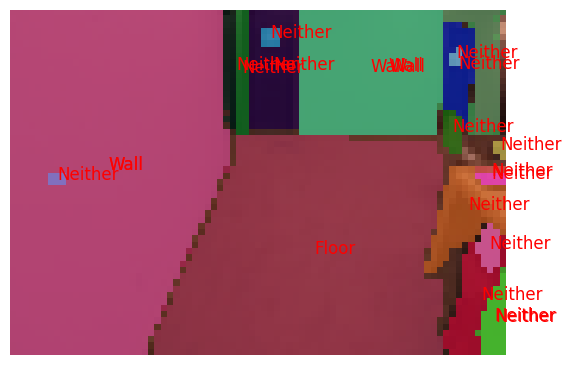

Driving W. Scene explanation: The scene is mostly filled with walls, with a clear path of floor towards the bottom. The plan is to move forward (W) to navigate through the clear space.


In [36]:
process_image_and_generate_direction(processed_images, show_masks_on_image)